In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [191]:
def simulate_fee(_fee, cfee, print_result=True, market_size_prediction=None):
    ########## Assumptions ##########
    # market size prediction according to Sharing Economy Association Japan
    # using quantity theory of money for utility value of token
    # income approach (discounted cash flow) for goverance value of token
    # discount rate 20%
    # token velocity 0.25
    # floating factor = 0.25
    # terminal growth rate = 3%
    # maximum 1 million yen for advertizing cost for first 5 years
    # increasing contributor cost ranging 5 million ~ 15 million yen
    # decreasing stickiness over time

    year = [i for i in range(2024, 2034)]

    def update_share(U_=None, Uc=None, token_util=0.2, gas = 0.001, _fee=0.1, stickiness=12, cfee=0.2):
        #update market share and stickiness]# how to simulate market share:
    ## share D is a function of comparative utility against competitor at time t and stickiness
    ## D(U_ - Uc) where U_ is utility from our platform, Uc is utility from competitor's platform
    ### U_ = f(fee, gas, token_util), domain = [0, 1]
    ### Uc = f(fee, barrier_strategy), domain = [0, 1]
    ### D is defined in domain [0, 1] where 1 means 100% market share
    # stickiness 
    ## stickiness constant s represents how sticky the user is to existing platform.
        if not U_:
            U_ = 1 - _fee + token_util - gas
        if not Uc:
            Uc = 1 - cfee
        Udif = U_ - Uc
        D = max((1/np.e**stickiness)*(np.e**(stickiness*Udif)), 0)
        return D, stickiness

    def update_state(market_share_t, market_size_t, cumulative_gov_value_prev, t, discount_rate=0.2, cost_t=50e5, token_velocity=0.25, floating=0.25, token_supplycap=10e6, terminal_growth_rate=0.03, adv_cost=0, cfee=0.2, _fee=0.1):
        #update utility value of token
        #update governance value of token
        #update token supply
        cost_t += adv_cost
        revenue_t = market_share_t*market_size_t
        profit_t = revenue_t*(_fee/0.2) - cost_t
        util_value_t = market_size_t * market_share_t / (token_velocity*floating) / (1+discount_rate)**t # total token value, not per token
        gov_value_t = profit_t/(1+discount_rate)**t
        cumulative_gov_value_t = cumulative_gov_value_prev + gov_value_t
        gov_value_terminal = profit_t/(discount_rate-terminal_growth_rate)/(1+discount_rate)**t
        return (util_value_t, gov_value_t, cumulative_gov_value_t, gov_value_terminal)

    # set market prediction
    if not market_size_prediction:
        market_size_prediction = {2024:3000e8,
                                 2025:4207e8,
                                 2026:5414e8,
                                 2027:6622e8,
                                 2028:8193e8,
                                 2029:9765e8,
                                 2030:11337e8,
                                 2031:12909e8,
                                 2032:14481e8,
                                 2033:16000e8}
        
    token_supplies = [np.sqrt(10000000000000*i)+10000000 for i in range(0, 10)]


    #init
    cumulative_gov_value_t=0
    initial_cost = 30e5
    i=1
    s=14

    # store result
    util_value_list = []
    gov_value_list = []
    cumulative_gov_value_list = []
    profit_list = []
    market_shares = []

    # run simulation
    for t in range(2024, 2034):
        adv = 10e5 if i<6 else 0
        contributor = i*5e5
        (market_share_t, s) = update_share(stickiness=s, _fee=_fee, cfee=cfee)
        market_size_t = market_size_prediction[t]
        (util_value_t, gov_value_t, cumulative_gov_value_t, gov_value_terminal) = update_state(market_share_t, market_size_t, cumulative_gov_value_t, i, cost_t=30e5+contributor, adv_cost=adv, _fee=_fee, cfee=cfee)
        util_value_list.append(util_value_t)
        gov_value_list.append(gov_value_t)
        cumulative_gov_value_list.append(cumulative_gov_value_t)
        market_shares.append(market_share_t)
        i+=1
        s-=0.2
        
    if print_result:
        print("Discounted utility value of token in 10 years:", "¥"+f"{round(util_value_t/1e9, 4)} billion")
        print("Discounted governance value of token in 10 years:", "¥"+f"{round(gov_value_t/1e9, 4)} billion")
        print("Terminal governance value of token:", "¥"+f"{round(gov_value_terminal/1e9, 4)} billion")
        print("Total token value without terminal value in 10 years:", "¥"+f"{round((util_value_t+gov_value_t)/1e9, 4)} billion")
        print("Total token value with terminal value in 10 years:", "¥"+f"{round((util_value_t+gov_value_t+gov_value_terminal)/1e9, 4)} billion")
        print("Token supply in 10 years:",f"{round(max(token_supplies)/1e6, 4)} million")
        print("NPV with terminal value of the platform:", "¥"+f"{round((cumulative_gov_value_t+gov_value_terminal)/1e9, 4)} billion")
        print("minimum initial fund needed (can be multi-stage):", "¥"+f"{round(-min(min(cumulative_gov_value_list)/1e6, 0), 4)+initial_cost} million")
        print("\n")

        plt.plot(np.array(cumulative_gov_value_list)/1e9)
        plt.title("discounted cumulative governance value (NPV) of token billion¥")
        plt.xticks([i for i in range(0,10)], year)
        plt.xlabel("year")
        plt.ylabel("value billion¥")
        plt.show()

        plt.plot(np.array(market_shares))
        plt.title("Simulated Market Share")
        plt.xticks([i for i in range(0,10)], year)
        plt.xlabel("year")
        plt.ylabel("market share")
        plt.show()

        plt.plot(np.array(gov_value_list)+np.array(util_value_list))
        plt.title("value of token at t")
        plt.xticks([i for i in range(0,10)], year)
        plt.xlabel("year")
        plt.ylabel("value ¥")
        plt.show()

        plt.plot(np.array(token_supplies))
        plt.title("token supply t")
        plt.xticks([i for i in range(0,10)], year)
        plt.xlabel("year")
        plt.ylabel("token supply")
        plt.show()

        plt.plot((np.array(gov_value_list)+np.array(util_value_list))/np.array(token_supplies))
        plt.title("value per token")
        plt.xticks([i for i in range(0,10)], year)
        plt.xlabel("year")
        plt.ylabel("value ¥")
        plt.show()

    lists = (util_value_list, gov_value_list, cumulative_gov_value_list, profit_list, market_shares, token_supplies)
    necessary_fund = -min(min(cumulative_gov_value_list), 0)
    
    return gov_value_t, necessary_fund, lists


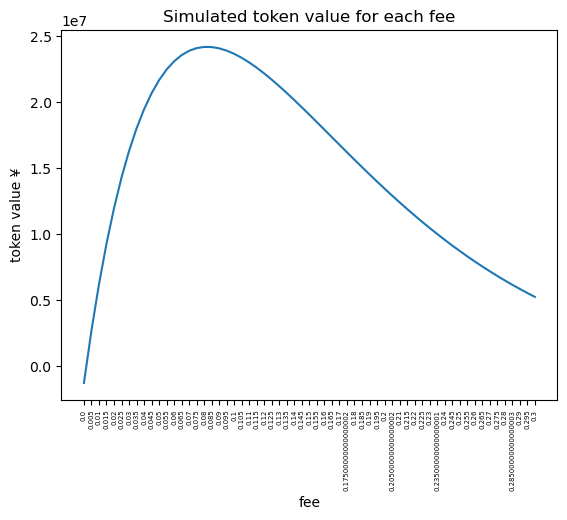

Optimum level of platform fee is 0.08


In [192]:
fees = [i*1e-3 for i in range(0, 301, 5)]
results = []
optimum_fee = 0
optimum_result = 0

for fee in fees:
    result = simulate_fee(fee, 0.2, print_result=False)[0]
    results.append(result)
    if result > optimum_result:
        optimum_result = result
        optimum_fee = fee

plt.plot(np.array(results))
plt.title("Simulated token value for each fee")
plt.xticks([i for i in range(len(fees))], fees)
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.xlabel("fee")
plt.ylabel("token value ¥")
plt.show()

print(f"Optimum level of platform fee is {optimum_fee}")

Discounted utility value of token in 10 years: ¥1.0191 billion
Discounted governance value of token in 10 years: ¥0.0242 billion
Terminal governance value of token: ¥0.1423 billion
Total token value without terminal value in 10 years: ¥1.0433 billion
Total token value with terminal value in 10 years: ¥1.1856 billion
Token supply in 10 years: 19.4868 million
NPV with terminal value of the platform: ¥0.2889 billion
minimum initial fund needed (can be multi-stage): ¥3000000.0 million




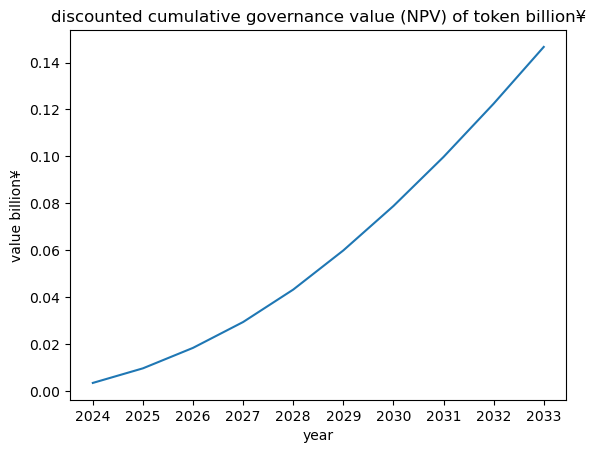

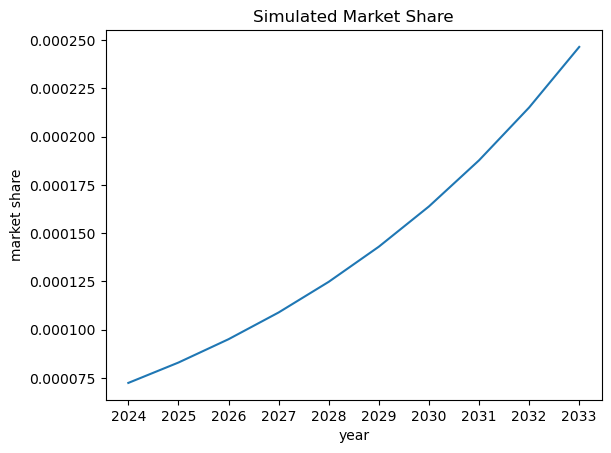

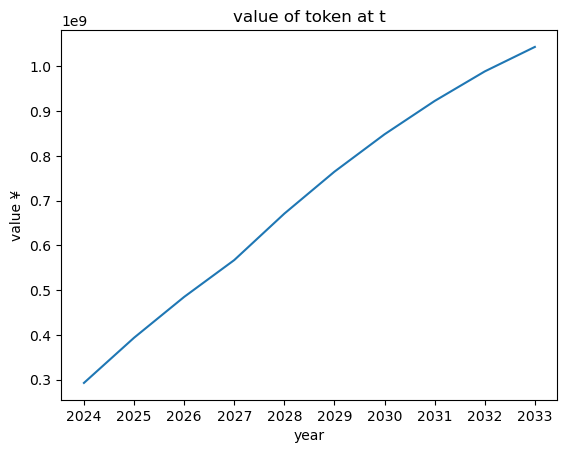

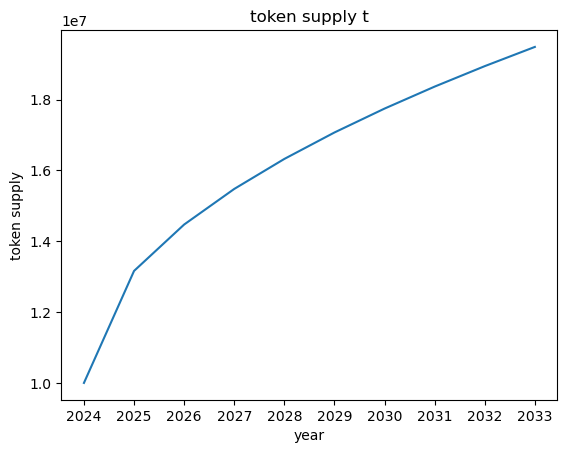

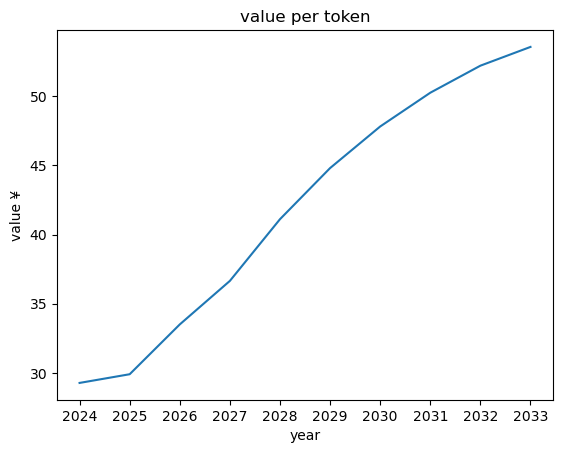

In [205]:
fee009 = simulate_fee(0.08, 0.2)

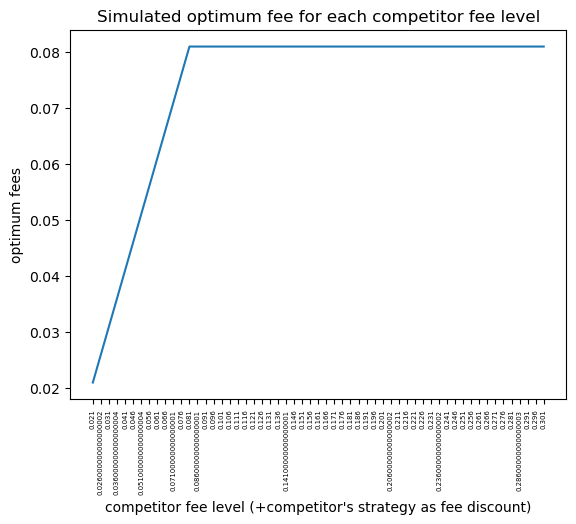

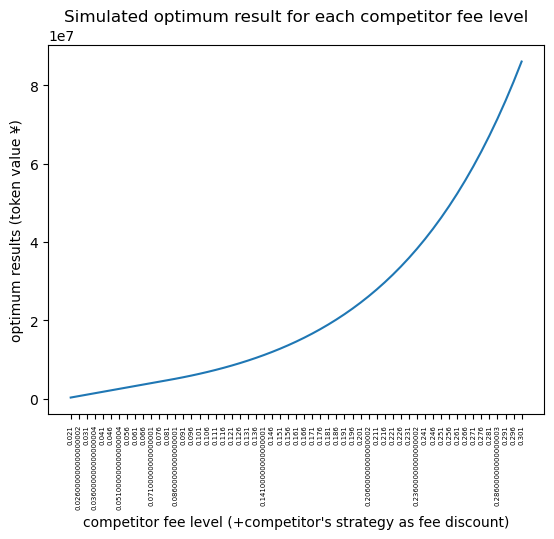

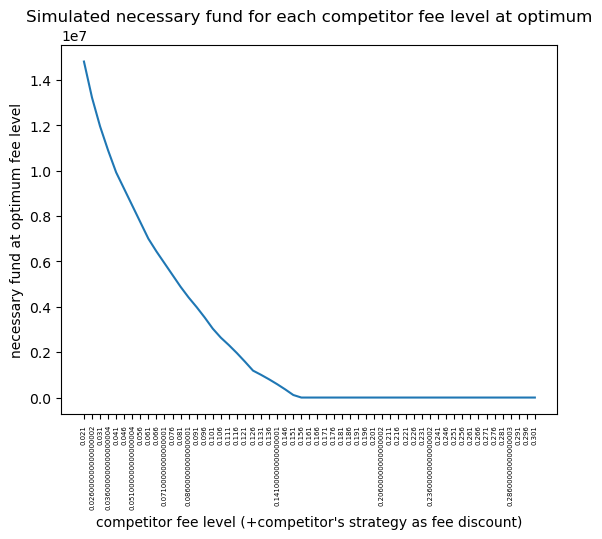

need ¥14810388.567921754 fund at worst case senario (in terms of competitor's strategy)


In [207]:
cfees = [i*1e-3 for i in range(21, 302, 5)]
fees = [i*1e-3 for i in range(1, 302, 5)]
optimum_fees = []
optimum_results = []
fund_at_optimum = []

for cfee in cfees:
    results = []
    optimum_fee = 0
    optimum_result = 0
    necessary_fund = 0

    for fee in fees:
        if fee<=cfee:
            output = simulate_fee(fee, cfee, print_result=False)
            result = output[0]
            fund = output[1]
            results.append(result)
            if result > optimum_result:
                optimum_result = result
                optimum_fee = fee
                necessary_fund = fund

    optimum_fees.append(optimum_fee)
    optimum_results.append(optimum_result)
    fund_at_optimum.append(necessary_fund)
    

plt.plot(np.array(optimum_fees))
plt.title("Simulated optimum fee for each competitor fee level")
plt.xticks([i for i in range(len(cfees))], cfees)
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.xlabel("competitor fee level (+competitor's strategy as fee discount)")
plt.ylabel("optimum fees")
plt.show()

plt.plot(np.array(optimum_results))
plt.title("Simulated optimum result for each competitor fee level")
plt.xticks([i for i in range(len(cfees))], cfees)
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.xlabel("competitor fee level (+competitor's strategy as fee discount)")
plt.ylabel("optimum results (token value ¥)")
plt.show()

plt.plot(np.array(fund_at_optimum))
plt.title("Simulated necessary fund for each competitor fee level at optimum")
plt.xticks([i for i in range(len(cfees))], cfees)
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.xlabel("competitor fee level (+competitor's strategy as fee discount)")
plt.ylabel("necessary fund at optimum fee level")
plt.show()

print(f"need ¥{max(fund_at_optimum)} fund at worst case senario (in terms of competitor's strategy)")



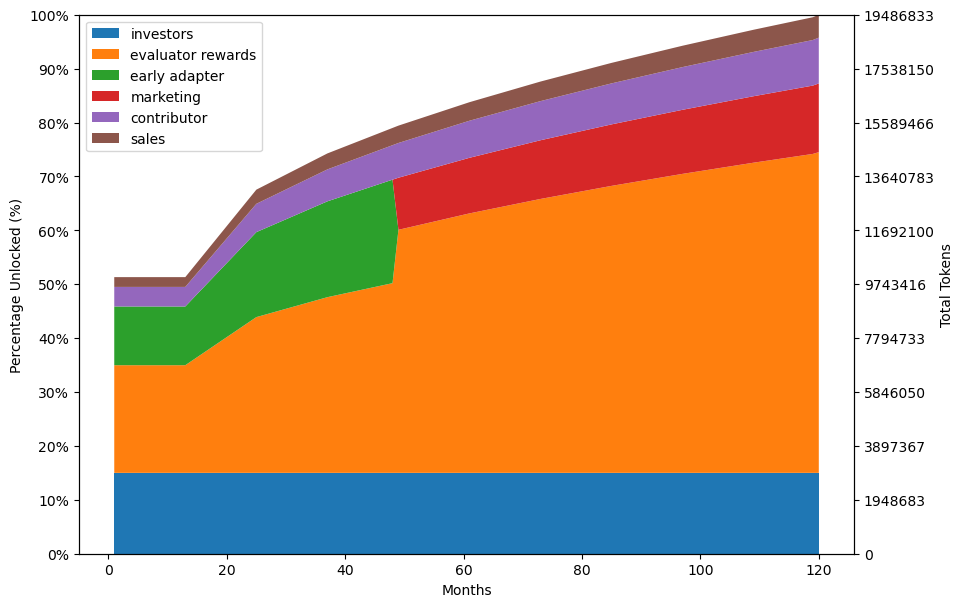

In [204]:
target_ratios = np.array([
    0.51316702, 0.67544468, 0.74266229, 0.79424017, 0.83772234,
    0.8760309, 0.91066448, 0.94251335, 0.97215756, 1.
])

unlocked_tokens = np.zeros(num_points)

unlocked_tokens[:12] = target_ratios[0]

for i in range(1, len(target_ratios)):
    start_index = i * 12
    end_index = (i + 1) * 12 if (i + 1) * 12 <= num_points else num_points
    unlocked_tokens[start_index:end_index] = np.linspace(
        target_ratios[i - 1], target_ratios[i], end_index - start_index, endpoint=False
    )

unlocked_tokens[-1] = 1.0

investors_data = np.full(num_points, fixed_ratios['investors'])
evaluator_rewards_data = np.zeros(num_points)
early_adapter_data = np.zeros(num_points)
contributor_data = np.zeros(num_points)
sales_data = np.zeros(num_points)
marketing_data = np.zeros(num_points)

for i in range(num_points):
    remaining = unlocked_tokens[i] - investors_data[i]
    if i < 48:
        evaluator_rewards_data[i] = remaining * variable_ratios['evaluator rewards']
    else:
        evaluator_rewards_data[i] = remaining * 0.70
    
    if i < 48:
        early_adapter_data[i] = remaining * variable_ratios['early adapter']
    
    contributor_data[i] = remaining * variable_ratios['contributor'] if i < 48 else remaining * 0.10
    
    sales_data[i] = remaining * variable_ratios['sales'] if i < 48 else remaining * 0.05
    
    if i >= 48:
        marketing_data[i] = remaining * 0.15

category_data = np.vstack((
    investors_data,
    evaluator_rewards_data,
    early_adapter_data,
    marketing_data, 
    contributor_data,
    sales_data
))


categories = ['investors', 'evaluator rewards', 'early adapter', 'marketing', 'contributor', 'sales']

secondary_y_values = np.array([
    10000000,
    13162278,
    14472136,
    15477226,
    16324555,
    17071068,
    17745967,
    18366600,
    18944272,
    19486833
])
primary_y_ticks = np.linspace(0, 1, 11)

secondary_y_values = primary_y_ticks * max_tokens

plt.figure(figsize=(10, 7))
months = np.arange(1, num_points + 1)
stacks = plt.stackplot(months, category_data, labels=categories)

plt.xlabel('Months')
plt.ylabel('Percentage Unlocked (%)')

plt.ylim(0, 1)
plt.yticks(primary_y_ticks, ['{:.0f}%'.format(y*100) for y in primary_y_ticks])

secondary_y = plt.gca().twinx()
secondary_y.set_ylim(0, 1)
secondary_y.set_yticks(primary_y_ticks)  # Match the primary y-axis ticks
secondary_y.set_yticklabels(['{:.0f}'.format(y) for y in secondary_y_values])  # Set the labels as integers

secondary_y.set_ylabel('Total Tokens')

plt.legend(handles=stacks, labels=categories, loc='upper left')

plt.show()

In [208]:
market_size_prediction_10off = {2024:3000e8*0.9,
                         2025:4207e8*0.9,
                         2026:5414e8*0.9,
                         2027:6622e8*0.9,
                         2028:8193e8*0.9,
                         2029:9765e8*0.9,
                         2030:11337e8*0.9,
                         2031:12909e8*0.9,
                         2032:14481e8*0.9,
                         2033:16000e8*0.9}

In [227]:
market_size_prediction_lowgrowth1 = {2024:3000e8,
                                 2025:4207e8*0.975,
                                 2026:5414e8*0.95,
                                 2027:6622e8*0.925,
                                 2028:8193e8*0.9,
                                 2029:9765e8*0.875,
                                 2030:11337e8*0.85,
                                 2031:12909e8*0.825,
                                 2032:14481e8*0.8,
                                 2033:16000e8*0.775}

In [225]:
market_size_prediction_lowgrowth2 = {2024:3000e8,
                                 2025:4207e8*0.975,
                                 2026:5414e8*0.95,
                                 2027:6622e8*0.925,
                                 2028:8193e8*0.9,
                                 2029:9765e8*0.85,
                                 2030:11337e8*0.8,
                                 2031:12909e8*0.75,
                                 2032:14481e8*0.7,
                                 2033:16000e8*0.65}

Discounted utility value of token in 10 years: ¥0.9172 billion
Discounted governance value of token in 10 years: ¥0.0216 billion
Terminal governance value of token: ¥0.1273 billion
Total token value without terminal value in 10 years: ¥0.9388 billion
Total token value with terminal value in 10 years: ¥1.0661 billion
Token supply in 10 years: 19.4868 million
NPV with terminal value of the platform: ¥0.2569 billion
minimum initial fund needed (can be multi-stage): ¥3000000.0 million




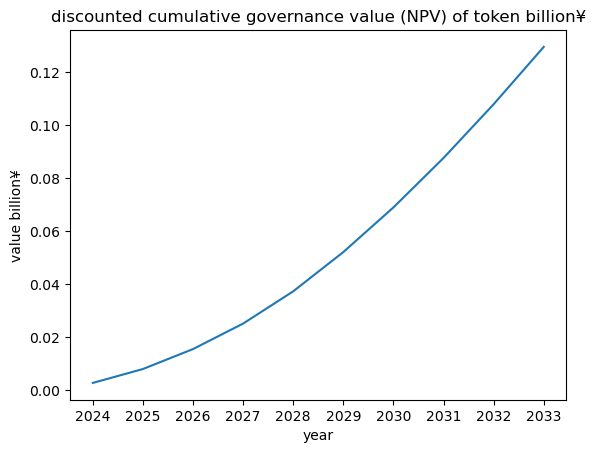

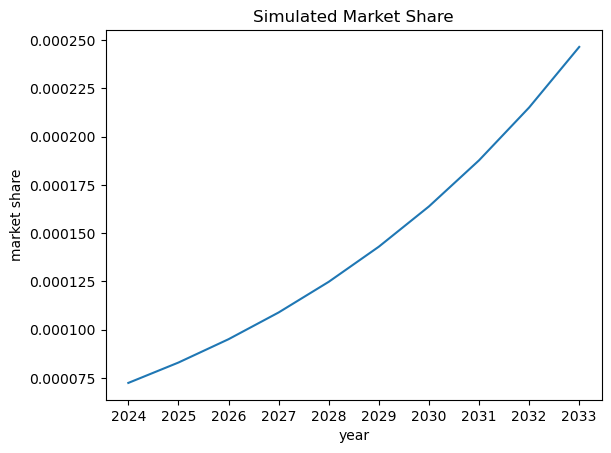

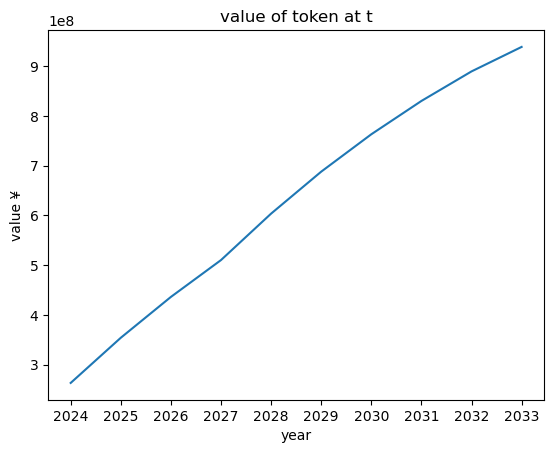

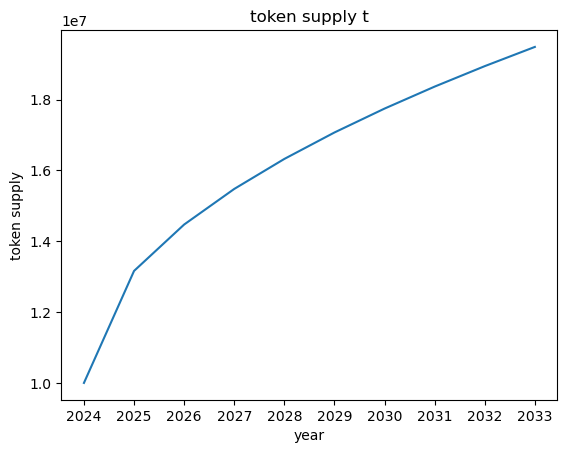

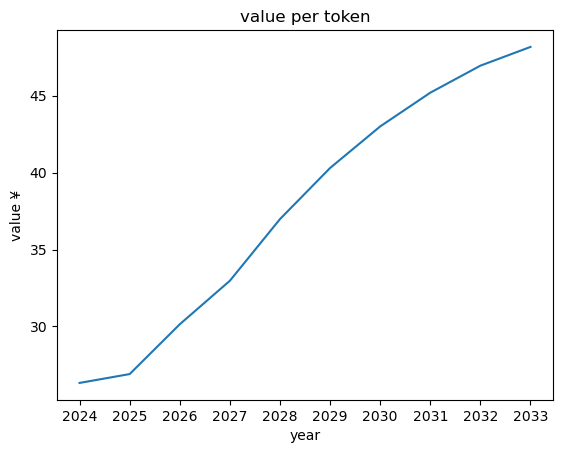

In [210]:
simulate_10off = simulate_fee(0.08, 0.2, market_size_prediction=market_size_prediction_10off)

Discounted utility value of token in 10 years: ¥0.7898 billion
Discounted governance value of token in 10 years: ¥0.0185 billion
Terminal governance value of token: ¥0.1085 billion
Total token value without terminal value in 10 years: ¥0.8083 billion
Total token value with terminal value in 10 years: ¥0.9168 billion
Token supply in 10 years: 19.4868 million
NPV with terminal value of the platform: ¥0.2317 billion
minimum initial fund needed (can be multi-stage): ¥3000000.0 million




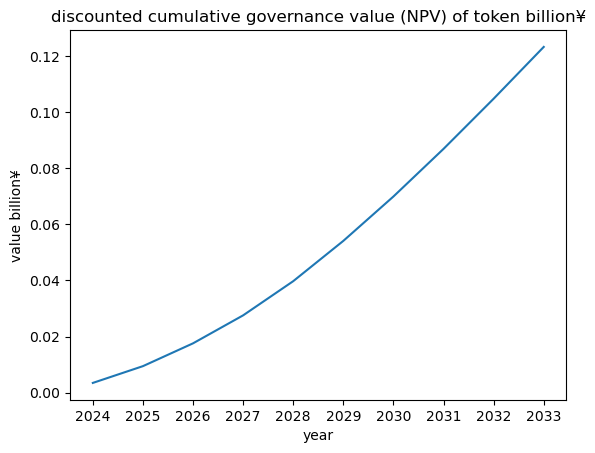

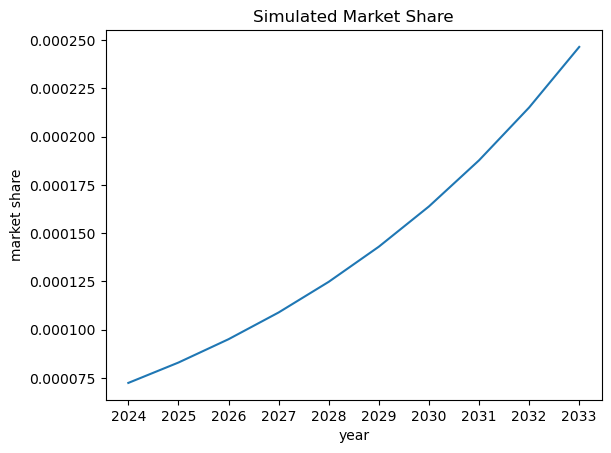

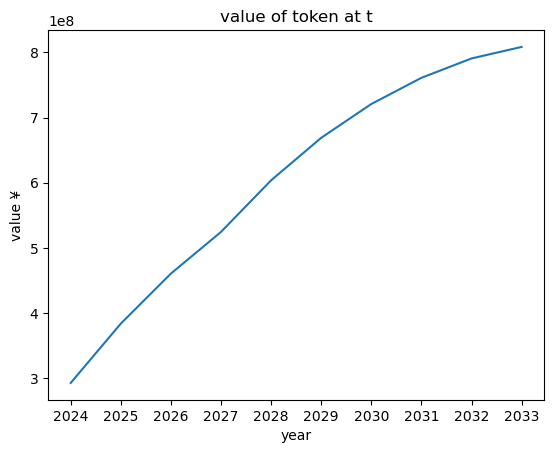

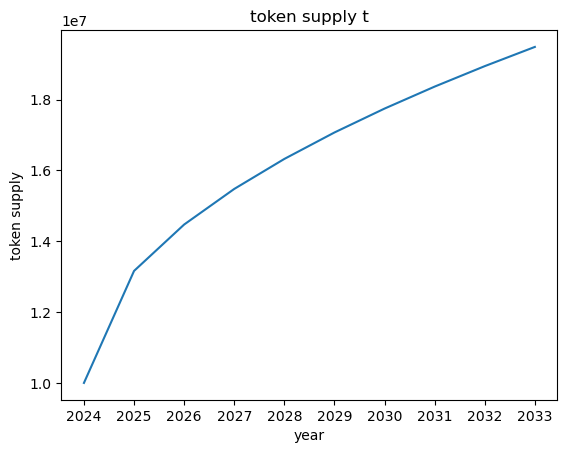

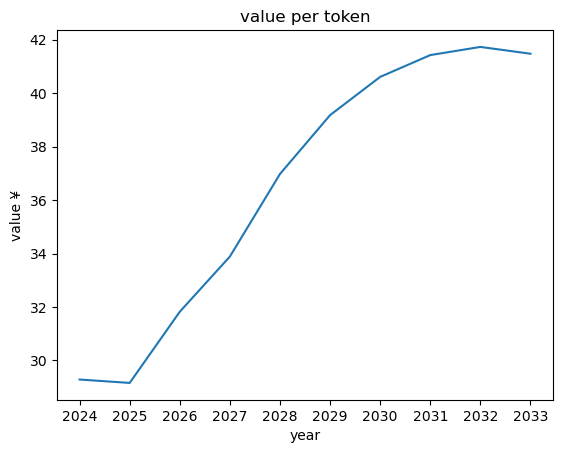

In [228]:
simulate_lowgrowth1 = simulate_fee(0.08, 0.2, market_size_prediction=market_size_prediction_lowgrowth1)


Discounted utility value of token in 10 years: ¥0.6624 billion
Discounted governance value of token in 10 years: ¥0.0153 billion
Terminal governance value of token: ¥0.0898 billion
Total token value without terminal value in 10 years: ¥0.6777 billion
Total token value with terminal value in 10 years: ¥0.7675 billion
Token supply in 10 years: 19.4868 million
NPV with terminal value of the platform: ¥0.2042 billion
minimum initial fund needed (can be multi-stage): ¥3000000.0 million




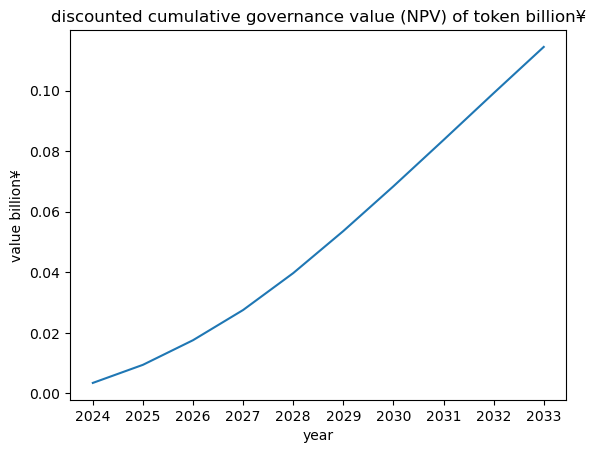

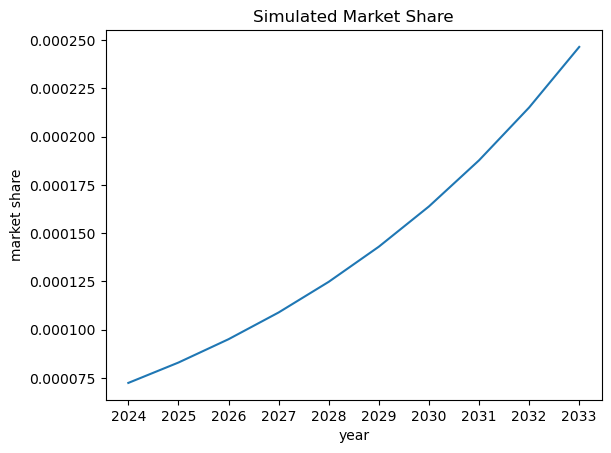

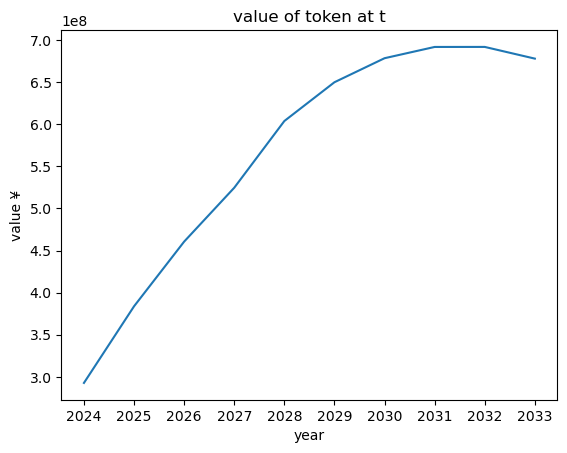

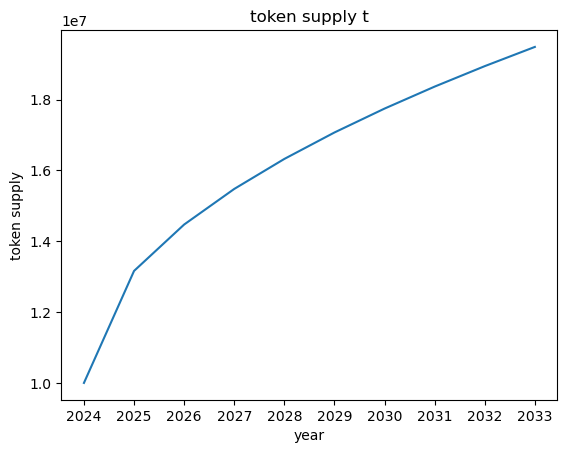

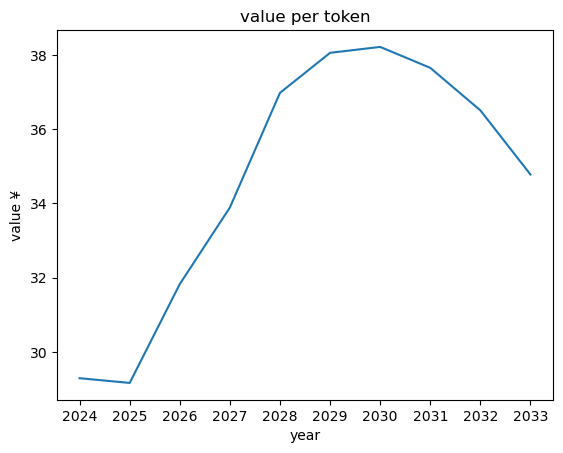

In [229]:
simulate_lowgrowth2 = simulate_fee(0.08, 0.2, market_size_prediction=market_size_prediction_lowgrowth2)


In [223]:
market_size_prediction = {2024:3000e8,
                         2025:4207e8,
                         2026:5414e8,
                         2027:6622e8,
                         2028:8193e8,
                         2029:9765e8,
                         2030:11337e8,
                         2031:12909e8,
                         2032:14481e8,
                         2033:16000e8}

Text(0.5, 1.0, 'market growth sensitivity of token value')

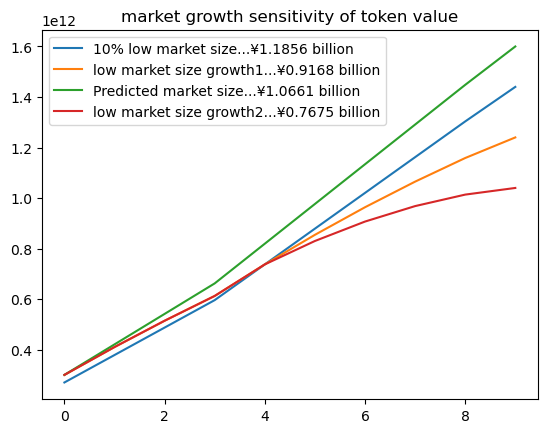

In [232]:
plt.plot(np.array(list(market_size_prediction_10off.values())), label="10% low market size...¥1.1856 billion")
plt.plot(np.array(list(market_size_prediction_lowgrowth1.values())), label="low market size growth1...¥0.9168 billion")
plt.plot(np.array(list(market_size_prediction.values())), label="Predicted market size...¥1.0661 billion")
plt.plot(np.array(list(market_size_prediction_lowgrowth2.values())), label="low market size growth2...¥0.7675 billion")
plt.legend()
plt.title("market growth sensitivity of token value")
